# Processing of the datasets

## 1. Imports and initial setup

In [71]:
%load_ext autoreload
%autoreload 1

from AirSeaFluxCode.AirSeaFluxCode import AirSeaFluxCode as asfc
import xarray as xr
import gsw_xarray as gsw
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from tqdm.notebook import tqdm_notebook as tqdm

%aimport my_funcs

my_funcs.update_params(fontsize=24)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Data loading and pre-processing

In [72]:
# Load SD1020 ADCP and dataset, squeeze and swap dimensions
ds20 = xr.open_dataset('../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc')\
        .squeeze().swap_dims({'obs':'time'})

# Load SD1022 and SD1023 datasets, and set coordinates
ds22 = xr.open_dataset('../data/Sd1022_data_merged.nc').set_coords(['longitude','latitude'])
ds23 = xr.open_dataset('../data/Sd1023_data_merged.nc').set_coords(['longitude','latitude'])

def fill_time(ds):
    df = ds.to_dataframe()
    ds = df.reindex(pd.date_range(start=df.index.min(),end=df.index.max(),freq='1min')).to_xarray().rename({"index":"time"})
    return ds

ds20 = fill_time(ds20)
ds22 = fill_time(ds22)
ds23 = fill_time(ds23)

ds22["UWND_MEAN"].loc[{"time": slice("2019-06-19 04:00", "2019-06-24 13:53")}] = -ds22["UWND_MEAN"].sel(time=slice("2019-06-19 04:00", "2019-06-24 13:53")).values
ds22["VWND_MEAN"].loc[{"time": slice("2019-06-19 04:00", "2019-06-24 13:53")}] = -ds22["VWND_MEAN"].sel(time=slice("2019-06-19 04:00", "2019-06-24 13:53")).values

ds23["UWND_MEAN"].loc[{"time": slice("2019-06-19 04:00", "2019-06-24 13:53")}] = -ds23["UWND_MEAN"].sel(time=slice("2019-06-19 04:00", "2019-06-24 13:53")).values
ds23["VWND_MEAN"].loc[{"time": slice("2019-06-19 04:00", "2019-06-24 13:53")}] = -ds23["VWND_MEAN"].sel(time=slice("2019-06-19 04:00", "2019-06-24 13:53")).values

# Set the values to NaN for the specified time range
ds22["UWND_MEAN"].loc[{"time": slice("2019-06-19 03:30", "2019-06-19 04:00")}] = np.nan
ds22["VWND_MEAN"].loc[{"time": slice("2019-06-19 03:30", "2019-06-19 04:00")}] = np.nan

ds23["UWND_MEAN"].loc[{"time": slice("2019-06-19 03:30", "2019-06-19 04:00")}] = np.nan
ds23["VWND_MEAN"].loc[{"time": slice("2019-06-19 03:30", "2019-06-19 04:00")}] = np.nan

datasets = [ds20, ds22, ds23]
labels = ['SD1020', 'SD1022', 'SD1023']

c20 = "#C13F89"  # Define color c20
c22 = "#00B4D8"  # Define color c22
c23 = "#0077B6"  # Define color c23
colors = [c20, c22, c23]


## 3. Plotting initial data

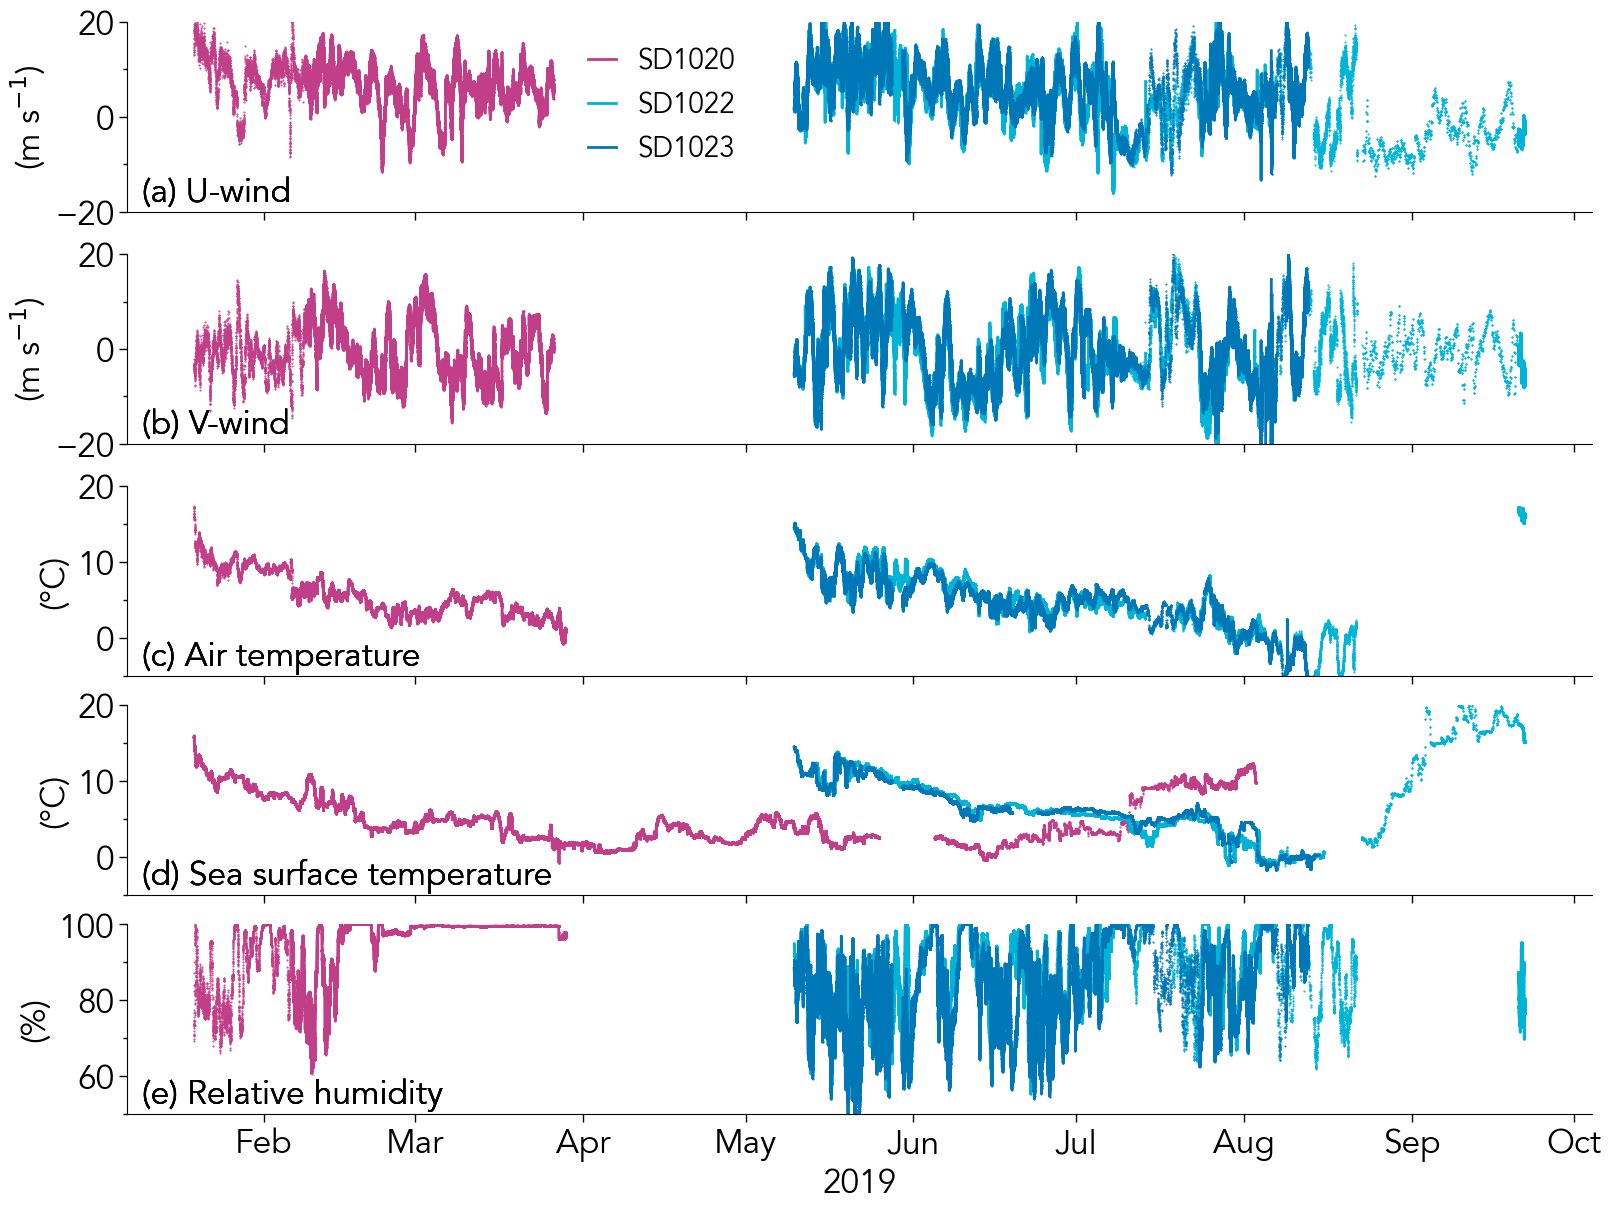

In [73]:
fig, axs = plt.subplots(5, 1, figsize=(16, 12), constrained_layout=True, sharex=True)

variables = ['UWND_MEAN', 'VWND_MEAN', 'TEMP_AIR_MEAN', 'TEMP_CTD_RBR_MEAN', 'RH_MEAN']
units = ["(m s$^{-1}$)", "(m s$^{-1}$)", "(°C)", "(°C)", "(%)"]
titles = ["U-wind", "V-wind", "Air temperature", "Sea surface temperature", "Relative humidity"]
ylims = [[-20, 20], [-20, 20], [-5, 20], [-5, 20], [50, 100]]
ymajorticks = [np.arange(-20, 21, 20), np.arange(-20, 21, 20), np.arange(0, 21, 10), np.arange(-0, 21, 10), np.arange(60, 101, 20)]
yminorticks = [np.arange(-20, 21, 10), np.arange(-20, 21, 10), np.arange(-5, 21, 5), np.arange(-5, 21, 5), np.arange(50, 101, 10)]

for ds, color, label in zip(datasets, colors, labels):
    for ax, var, unit, title, ylim, ymajortick, yminortick, letter in zip(axs, variables, units, titles, ylims, ymajorticks, yminorticks, string.ascii_lowercase):
        
        ds[var].where(np.isfinite(ds[var])).plot(ax=ax, c=color, lw=2, marker=".", ms=1, label=label)
        
        ax.set(ylim=ylim, yticks=ymajortick, xlabel="", ylabel=unit)
        ax.set_yticks(yminortick, minor=True)

        ax.text(0.01, 0.01, f"({letter}) {title}", fontweight="bold", transform=ax.transAxes, ha="left", va="bottom")
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    my_funcs.rot_ticks(ax, 0, "center")
    ax.set_xlabel('2019')

axs[0].legend(loc="upper center", ncol=1, bbox_to_anchor=(0.365, 1), frameon=False, fontsize="small", handlelength=1, ) 


Seems like the relative humidity is way off on SD1020, no way that it's that high for that long. That mean latent heat flux comparisons is a no go... Ah well...

## 4. Data quality evaluation

In [74]:
# Initialize lists to store masks and differences in mask indices
masks = []  # List to store masks for each dataset
dm = []  # List to store differences in mask indices for each dataset

# Loop through each dataset and set the position (y) and color for plotting
for ds in [ds20, ds22, ds23]:
    # Calculate a mask to select indices where all variables have finite values
    msk = np.where(np.logical_and(np.isfinite(ds["UWND_MEAN"]),
                                  np.logical_and(np.isfinite(ds["VWND_MEAN"]),
                                                 np.logical_and(np.isfinite(ds["TEMP_AIR_MEAN"]),np.isfinite(ds["TEMP_CTD_RBR_MEAN"])))))[0]
                                   #              np.isfinite(ds[var[4]]))))))[0]
    # Store the mask for later use
    masks.append(msk)
    # Calculate differences in mask indices
    dm.append(np.diff(msk))

In [75]:

t20 = ds20.time.copy() # Copy time array for each dataset
t22 = ds22.time.copy()
t23 = ds23.time.copy()

tds = [t20,t22,t23] # List to store time arrays for each dataset

for d,m,t,l in zip(dm,masks,tds,labels): # Loop through differences, masks, time arrays, and labels
    j = 0 # Initialize index
    print(f"----{l}----") # Print label
    if len(np.where(d>60)[0]) > 0: # If there are large gaps, print them. Large gaps are defined as gaps greater than 60 minutes.
        for i in np.where(d>60)[0]:
            print(f"{j} - {m[i]}: {((m[i]-j)/1440).round(1)} days")
            j = m[i+1]
            print(f"Gap of {((j-m[i])/60).round(1)} hours")
    else:
        print(f"0 - {m[-1]}: {np.round(m[-1]/1440,1)} days")
        print(f"No large gaps!")

----SD1020----
0 - 95632: 66.4 days
No large gaps!
----SD1022----
0 - 93409: 64.9 days
Gap of 118.0 hours
100490 - 128110: 19.2 days
Gap of 154.6 hours
137384 - 137384: 0.0 days
Gap of 13.3 hours
138180 - 140820: 1.8 days
Gap of 861.8 hours
----SD1023----
0 - 25915: 18.0 days
Gap of 48.1 hours
28800 - 57809: 20.1 days
Gap of 116.4 hours
64794 - 126840: 43.1 days
Gap of 1.2 hours
126910 - 128110: 0.8 days
Gap of 45.0 hours


## 5. Data interpolation

In [76]:
ds20i = ds20.isel(time=slice(0,95632)).interpolate_na( "time",max_gap=np.timedelta64(1,"h"))
ds22i = ds22.isel(time=slice(0,128110)).interpolate_na("time",max_gap=np.timedelta64(1,"h"))
ds23i = ds23.isel(time=slice(0,126840)).interpolate_na("time",max_gap=np.timedelta64(1,"h"))

## 6. Data quality control

In [77]:
def mean_vars(ds):
    var_to_save = [var for var in list(ds.columns) if "MEAN" in var]
    ds = ds[var_to_save]
    return list(ds.keys())

def std_vars(ds):
    var_to_save = [var for var in list(ds.columns) if "STDDEV" in var]
    ds = ds[var_to_save]
    return list(ds.keys())

In [78]:
df20 = ds20i.to_dataframe()
df22 = ds22i.to_dataframe()
df23 = ds23i.to_dataframe()

dataframes = [df20,df22,df23]

In [79]:
dataframes_qc = []
datasets_qc = []
for df in tqdm(dataframes):
    means = mean_vars(df)
    stds  = std_vars(df)
    for mean,std in tqdm(zip(means,stds),total=len(means),leave=False):
        df[mean] = df[mean].where(np.abs(df[std]) < np.nanpercentile(np.abs(df[std]),95))

    df = df.to_xarray().interpolate_na( "time",max_gap=np.timedelta64(1,"h"))
    df = df.rolling(time=5,center=True).median("time").isel(time=slice(2,-2)).to_dataframe()

    ds = df.to_xarray().interpolate_na( "time",max_gap=np.timedelta64(1,"h"))
    ds = ds.rolling(time=5,center=True).median("time").isel(time=slice(2,-2))
    
    datasets_qc.append(ds)
    dataframes_qc.append(df)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [80]:
ds20qc = datasets_qc[0]
ds22qc = datasets_qc[1]
ds23qc = datasets_qc[2]

In [81]:
for ds,l in zip(datasets_qc,labels):
    print(f"----{l}----")
    for v in variables:
        print(v,len(np.where(~np.isfinite(ds[v].interpolate_na( "time",max_gap=np.timedelta64(1,"h")).values))[0]))

----SD1020----
UWND_MEAN 505
VWND_MEAN 415
TEMP_AIR_MEAN 0
TEMP_CTD_RBR_MEAN 3
RH_MEAN 139
----SD1022----
UWND_MEAN 4
VWND_MEAN 597
TEMP_AIR_MEAN 7102
TEMP_CTD_RBR_MEAN 1
RH_MEAN 7099
----SD1023----
UWND_MEAN 3044
VWND_MEAN 3688
TEMP_AIR_MEAN 2896
TEMP_CTD_RBR_MEAN 9878
RH_MEAN 2893


## 7. Calculate wind speed and turbulent fluxes

In [82]:
def calc_ws(ds):
    ds['wind_speed'] = np.sqrt(ds['UWND_MEAN']**2 + ds['VWND_MEAN']**2)
    return ds

In [83]:
def calc_tasf(ds):
    """
    Calculate turbulent air-sea fluxes and reference temperature.

    Parameters:
    ds (xarray.Dataset): The dataset containing the necessary variables.
    SST (str): The name of the sea surface temperature variable in the dataset.

    Returns:
    xarray.Dataset: The dataset with added turbulent fluxes and reference temperature.
    """
    
    # Calculate sensible heat flux and 10m wind speed
    air_hum = asfc(
        np.asarray(ds["wind_speed"]),            # Wind speed 
        np.asarray(ds["TEMP_AIR_MEAN"]),         # Air temperature
        np.asarray(ds["TEMP_CTD_RBR_MEAN"]),     # Sea surface temperature
        "skin", 
        meth="C35", 
        lat=np.asarray(ds["latitude"]),          # Latitude
        hin=[3.68, 2.5, 2.5],                    # Heights of input variables
        hout=10,                                 # Output height for wind speed
        hum=["rh", np.asarray(ds["RH_MEAN"])],   # Relative humidity
        out_var=['sensible', "uref"]             # Output variables: sensible heat flux and 10m wind speed
    )
    
    # Assign calculated sensible heat flux and 10m wind speed to the dataset
    ds['sensible'] = (list(ds.dims)[0], air_hum['sensible'])
    ds['u10'] = (list(ds.dims)[0], air_hum['uref'])

    # Calculate reference temperature at 2m height
    air_hum = asfc(
        np.asarray(ds["wind_speed"]),            # Wind speed 
        np.asarray(ds["TEMP_AIR_MEAN"]),         # Air temperature
        np.asarray(ds["TEMP_CTD_RBR_MEAN"]),     # Sea surface temperature
        "skin", 
        meth="C35", 
        lat=np.asarray(ds["latitude"]),          # Latitude
        hin=[3.68, 2.5, 2.5],                    # Heights of input variables
        hout=2,                                  # Output height for reference temperature
        hum=["rh", np.asarray(ds["RH_MEAN"])],   # Relative humidity
        out_var=["tref"]                         # Output variable: reference temperature
    )
    
    # Assign calculated reference temperature to the dataset and convert from Kelvin to Celsius
    ds['t2m'] = (list(ds.dims)[0], air_hum['tref'] - 273.15)
    
    return ds

In [84]:
ds20qc = calc_ws(ds20qc)
ds22qc = calc_ws(ds22qc)
ds23qc = calc_ws(ds23qc)

ds20qc = calc_tasf(ds20qc)
ds22qc = calc_tasf(ds22qc)
ds23qc = calc_tasf(ds23qc)

## 8. Plotting sensible heat flux

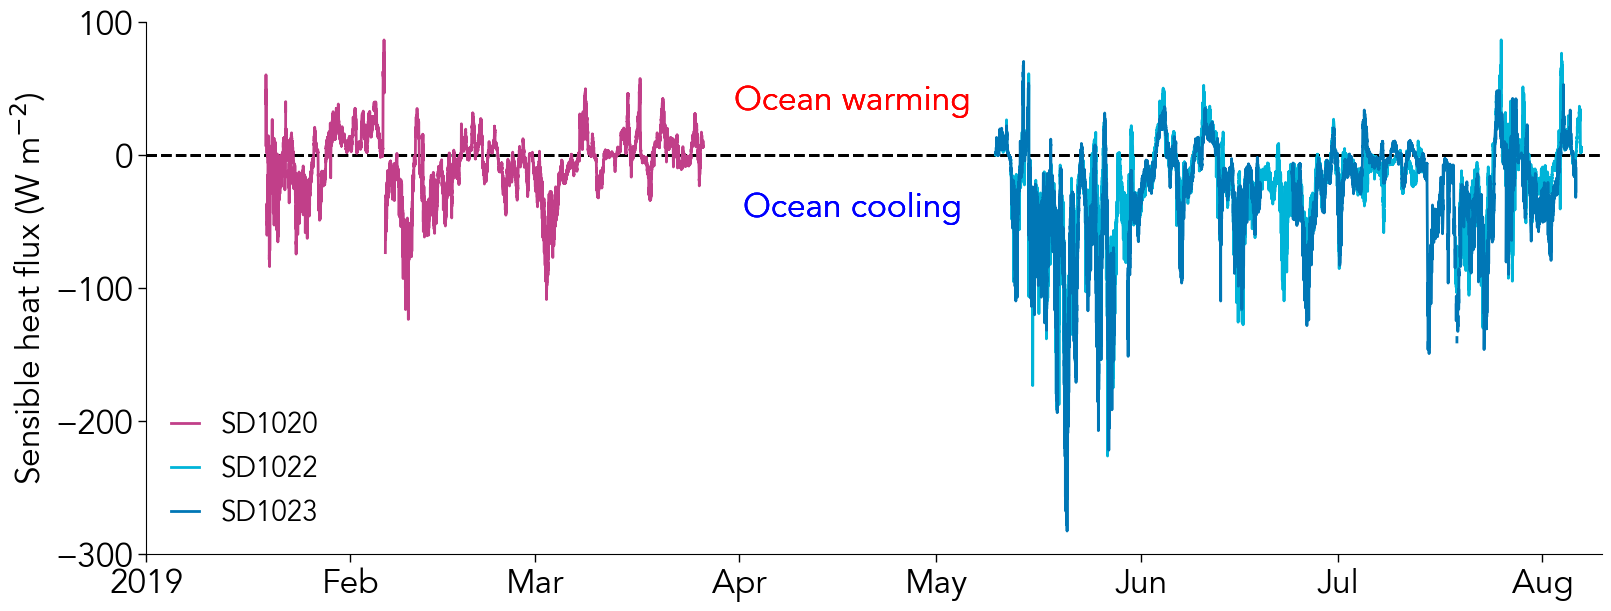

In [85]:
fig, ax = plt.subplots(1,1,figsize=(16, 6), constrained_layout=True)

for ds, c, l in zip([ds20qc, ds22qc, ds23qc], colors, labels):
    ds["sensible"].plot(ax=ax, c=c, lw=2, zorder=3, label=l)
    ax.set(xlabel="", ylabel=r"Sensible heat flux (W m$^{-2}$)", ylim=(-300, 100), xlim=(np.datetime64("2019-01-01"), np.datetime64("2019-08-10")))
    ax.axhline(0, ls="--", c='k', lw=2, zorder=2)
    ax.text(0.485, 0.85, "Ocean warming", ha="center", va="center", c="r", transform=ax.transAxes)
    ax.text(0.485, 0.65, "Ocean cooling", ha="center", va="center", c="b", transform=ax.transAxes)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
my_funcs.rot_ticks(ax, 0, 'center')
ax.legend(frameon=False, loc="lower left", ncol=1, fontsize="small", handlelength=1)

plt.show()

## 9. Saving processed time series data

In [87]:
ds20qc.to_netcdf("../data/ds20qc_1min_height.nc")
ds22qc.to_netcdf("../data/ds22qc_1min_height.nc")
ds23qc.to_netcdf("../data/ds23qc_1min_height.nc")

## 10. Gridding in space

In [88]:
ds20qc["distance"] = ("time"), np.nancumsum(np.insert(gsw.distance(ds20qc.longitude.interpolate_na("time",max_gap=np.timedelta64(1,"h")),
                                                                ds20qc.latitude.interpolate_na("time",max_gap=np.timedelta64(1,"h"))),0,0))/1000
ds22qc["distance"] = ("time"), np.nancumsum(np.insert(gsw.distance(ds22qc.longitude.interpolate_na("time",max_gap=np.timedelta64(1,"h")),
                                                                ds22qc.latitude.interpolate_na("time",max_gap=np.timedelta64(1,"h"))),0,0))/1000
ds23qc["distance"] = ("time"), np.nancumsum(np.insert(gsw.distance(ds23qc.longitude.interpolate_na("time",max_gap=np.timedelta64(1,"h")),
                                                                ds23qc.latitude.interpolate_na("time",max_gap=np.timedelta64(1,"h"))),0,0))/1000

In [89]:
ds20qcd = ds20qc.swap_dims({"time": "distance"})
idx = ~ds20qcd.to_dataframe().index.duplicated(keep='first')
ds20qcd = ds20qcd.isel(distance=idx)
ds20qcd = ds20qcd.interp(distance=np.arange(0, np.nanmax(ds20qcd["distance"].values), 0.2))

ds22qcd = ds22qc.swap_dims({"time": "distance"})
idx = ~ds22qcd.to_dataframe().index.duplicated(keep='first')
ds22qcd = ds22qcd.isel(distance=idx)
ds22qcd = ds22qcd.interp(distance=np.arange(0, np.nanmax(ds22qcd["distance"].values), 0.2))

ds23qcd = ds23qc.swap_dims({"time": "distance"})
idx = ~ds23qcd.to_dataframe().index.duplicated(keep='first')
ds23qcd = ds23qcd.isel(distance=idx)
ds23qcd = ds23qcd.interp(distance=np.arange(0, np.nanmax(ds23qcd["distance"].values), 0.2))

In [90]:
ds20qcd.to_netcdf("../data/ds20qc_1min_200m.nc")
ds22qcd.to_netcdf("../data/ds22qc_1min_200m.nc")
ds23qcd.to_netcdf("../data/ds23qc_1min_200m.nc")

In [91]:
datasets = [ds20qcd, ds22qcd, ds23qcd]

for ds, l in zip(datasets, labels):
    print(f"{l}:", ds["distance"].max().values.round(1), "km")

SD1020: 9804.8 km
SD1022: 13063.4 km
SD1023: 12771.0 km


In [92]:
fig, axs = plt.subplots(4, 1, figsize=(16, 12), constrained_layout=True, sharex=True, dpi=600)

variables = ["u10", "t2m", "TEMP_CTD_RBR_MEAN", "sensible"]
names = ["10-m wind speed", "2-m air temperature", "Sea surface temperature", "Sensible heat flux"]
units = ["(m s$^{-1}$)", "(°C)", "(°C)", "(W m$^{-2}$)"]
ylims = [[0, 25], [-5, 20], [-5, 20], [-300, 100]]
ymajorticks = [np.arange(0, 21, 10), np.arange(-0, 21, 10), np.arange(-0, 21, 10), np.arange(-300, 101, 100)]
yminorticks = [np.arange(0, 26, 5), np.arange(-5, 21, 5), np.arange(-5, 21, 5), np.arange(-300, 101, 50)]


for ds, color, label in zip(datasets, colors, labels):
    for ax, var, name, unit, ylim, ymajortick, yminortick, letter in zip(axs, variables, names, units, ylims, ymajorticks, yminorticks, string.ascii_lowercase):
        ds[var].plot(ax=ax, c=color, lw=1, label=label)
        ax.set(ylim=ylim, yticks=ymajortick, ylabel=unit)
        ax.set_yticks(yminortick, minor=True)
        ax.text(0.01, 0.05, f"({letter}) {name}", 
                fontsize="small", transform=ax.transAxes,
                  ha="left", va="bottom", bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Along-track distance (km)' if name == "Sensible heat flux" else "")
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.set_xlim(0, 13500)
leg = axs[1].legend(loc="upper center", ncol=3, frameon=False, fontsize="small", handlelength=1)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

axs[0].set_title("Along-track variations in meteorological and oceanographic variables", fontsize=24)

axs[2].text(2750,5, "Summer?", fontsize=24, color=c20, ha="center", va="center")
axs[2].text(2750,15, "Winter?", fontsize=24, color=c23, ha="center", va="center")


plt.show()
